# Homework 8

## Standard form LP barrier method
In the following three exercises, you will implement a barrier method for solving the standard
form LP
\begin{align}
  \text{minimize} & \quad c^\top x \\
  \text{subject to} & \quad Ax = b \\
  & \quad  x \succeq 0
\end{align}
with variable $x \in \mathbb{R}^n, A \in \mathbb{R}^{m \times n}, m < n$. Throughout this exercise we will
assume that A is full rank, and the sublevel sets $\{x | Ax = b, x \succeq 0, c^\top x \leq \gamma\}$ are all
bounded. (If this is not the case, the centering problem is unbounded below.)

### Centering Step
Centering step. Implement Newton’s method for solving the centering problem
\begin{align}
  \text{minimize} & \quad c^\top x - \sum_{i=1}^n \log x_i \\
  \text{subject to} & \quad Ax = b
\end{align}
with variable $x$, given a strictly feasible starting point $x_0$. <br> <br>
Your code should accept $A,b,c, \text{ and } x_0$, and return $x^*$, the primal optimal point, $\nu^*$, a dual optimal point, and the number of Newton steps executed. <br> <br>
Use the block elimination method to compute the Newton step. (You can also compute
the Newton step via the KKT system, and compare the result to the Newton step
computed via block elimination. The two steps should be close, but if any $x_i$
is very small, you might get a warning about the condition number of the KKT matrix.) <br> <br>
Plot $\lambda^2/2$ versus iteration $k$, for various problem data and initial points, to verify that
your implementation gives asymptotic quadratic convergence. As stopping criterion,
you can use $\lambda^2/2 \leq 10^{-6}$. Experiment with varying the algorithm parameters $\alpha$ and $\beta$,
observing the effect on the total number of Newton steps required, for a fixed problem
instance. Check that your computed $x^*, \nu^*$
(nearly) satisfy the KKT conditions. <br> <br>
To generate some random problem data (i.e., $A, b, c, x_0$), we recommend the following
approach. First, generate $A$ randomly. (You might want to check that it has full rank.)
Then generate a random positive vector $x_0$, and take $b = Ax_0$. (This ensures that $x_0$
is strictly feasible.) The parameter $c$ can be chosen randomly. To be sure the sublevel
sets are bounded, you can add a row to $A$ with all positive elements. If you want to
be able to repeat a run with the same problem data, be sure to set the state for the
uniform and normal random number generators.
Here are some hints that may be useful.

* We recommend computing $\lambda^2/2$ using the formula $\lambda^2 = - \Delta x_{nt}^\top \nabla f(x)$. You don’t really need $\lambda$ for anything; you can work with $\lambda^2$ instead. (This is important for reasons described below.)
* There can be small numerical errors in the Newton step $\Delta x_{nt}$ that you compute. When $x$ is nearly optimal, the computed value of $\lambda$ can actually be (slightly) negative. If you take the squareroot to get $\lambda$, you’ll get a complex number, and you’ll never recover. Moreover, your line search will never exit. However, this only happens when $x$ is nearly optimal. So if you exit on the condition $\lambda^2/2 \leq 10^{-6}$, everything will be fine, even when the computed value of $\lambda^2$ is negative.
* For the line search, you must first multiply the step size $t$ by $\beta$ until $x + t \Delta x_{nt}$ is feasible (i.e., strictly positive). If you don’t, when you evaluate $f$ you’ll be taking the logarithm of negative numbers, and you’ll never recover.


In [8]:
import numpy as np

#Problem dimensions
m = 100
n = 200

#Problem parameters
def create_problem_params(m=100,n=200):
    A = np.random.randn(m-1,n) * 10
    A = np.r_[A,np.random.rand(n).reshape(1,-1)]
    x_0 = np.random.rand(n)
    b = A @ x_0
    c = np.random.rand(n) * 20 + 5

    return A, x_0, b, c

A, x_0, b, c = create_problem_params()

b.shape, A.shape

((100,), (100, 200))

In [9]:
#Functions and derivatives
def f(x:np.array, c:np.array):
    x = np.maximum(x, 1e-8)
    return c.T @ x - np.sum(np.log(x))

def g(x:np.array, c:np.array):
    return c - 1/x

def H(x:np.array,c:np.array = None):
    H = np.diag((x**(-2)))
    eI = np.identity(x.shape[0]) * 10e-9
    return H + eI

def H_inv(x: np.array, c:np.array = None):
    H_inv = np.diag((x**(2)))
    eI = np.identity(x.shape[0]) * 10e-9
    return np.diag((x**2))

print(f"f(x) = {f(x_0,c)}")    
print(f"g(x) shape:  {(g(x_0,c)).shape}")    
print(f"H(x) shape:  {(H(x_0,c)).shape}")    

f(x) = 1679.6428948237976
g(x) shape:  (200,)
H(x) shape:  (200, 200)


In [10]:
# Problem Parameters
A, x_0, b, c = create_problem_params()

# Backtracking parameters
alpha = 0.1
beta = 0.3

# Stopping Criterion
epsilon = 1e-8
max_iter = 100


def append_results(results, x, f_x, g_x, H_x, dx, lambda_2, iter, nu, gap = None):
    results["x"].append(x)
    results["f_x"].append(f_x)
    results["g_x"].append(g_x)
    results["H_x"].append(H_x)
    results["dx"].append(dx)
    results["lambda_2"].append(lambda_2)
    results["iter"].append(iter)
    results["nu"].append(nu)
    if gap is not None:
        results["gap"].append(gap)

def backtracking_line_search(x, dx, alpha, beta, c):
    t = 1
    while (f(x + t * dx,c) > f(x,c) + alpha * t * g(x,c).T @ dx) or np.isnan(f(x + t * dx,c)):
        t *= beta
        if t < 1e-20:
            break
    return t


def newtons_centering_step(A, x_0, b, c, alpha, beta, epsilon, max_iter):
    # Storing results
    results = {
        "x": [],
        "f_x" : [],
        "g_x" : [],
        "H_x" : [],
        "dx": [],
        "lambda_2": [],
        "iter": [],
        "nu": [],
    }
    
    # Givens
    x = x_0
    i = 0


    while i <= max_iter:
        x = np.maximum(x, 1e-8)
        # Compute gradients and hessians
        f_x = f(x, c)
        g_x = g(x, c)
        H_x = H(x, c)
        H_x_inv = H_inv(x, c)
        

        # Compute Newton step and decrement
        w = np.linalg.solve((A @ H_x_inv @ A.T), (-A @ H_x_inv @ g_x))
        dx_nt = - H_x_inv @ (A.T @ w + g_x)
        nt_dec_2 = - dx_nt.T @ g_x
        
        # Stopping Criterion
        if nt_dec_2 / 2 <= epsilon:
            break

        # Line Search
        t_search = backtracking_line_search(x, dx_nt, alpha, beta, c)
        
        # Update
        x = x + t_search * dx_nt

        # Iteration update
        i += 1

        # Append to results lists
        append_results(results, x, f_x, g_x, H_x, dx_nt, nt_dec_2, i, w)

    # Newton Complete Certificate
    p_star = n + np.sum(np.log(np.maximum(c + A.T @ w,1e-9))) - w.T @ b
    print(f"""
    Newtons Step completed in {i} iterations
    Duality Gap f(x^*) - p^* = {f(x,c) - p_star}
    KKT conditions satisfied with accuracy of {np.linalg.norm(g(x,c) + w.T @ A,2)}
    """)
    return results

my_results = newtons_centering_step(A, x_0, b, c, alpha, beta, epsilon, max_iter)
my_results.keys()


    Newtons Step completed in 14 iterations
    Duality Gap f(x^*) - p^* = -1.1823431123048067e-11
    KKT conditions satisfied with accuracy of 1.097135823504657e-06
    


dict_keys(['x', 'f_x', 'g_x', 'H_x', 'dx', 'lambda_2', 'iter', 'nu'])

Text(0.5, 1.0, 'Newton Decrement vs Iteration')

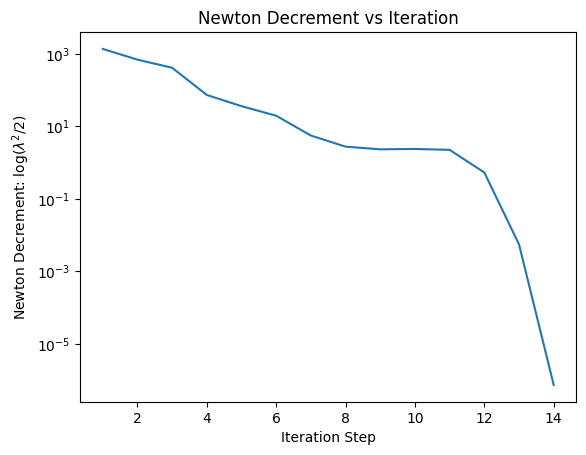

In [11]:
import matplotlib.pyplot as plt
# Plotting the results

plt.plot(my_results["iter"], my_results["lambda_2"])
plt.yscale("log")
plt.ylabel("Newton Decrement: log($\lambda^2 / 2 $)")
plt.xlabel("Iteration Step")
plt.title("Newton Decrement vs Iteration")

Text(0.5, 1.0, 'f(x) vs Iteration')

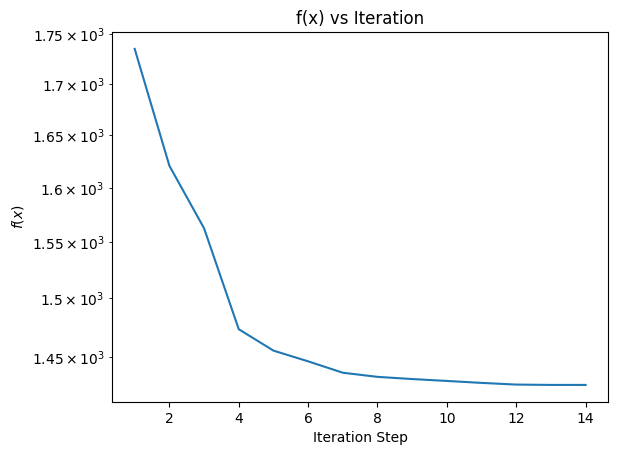

In [12]:
plt.plot(my_results["iter"], my_results["f_x"])
plt.yscale("log")
plt.ylabel("$f(x)$")
plt.xlabel("Iteration Step")
plt.title("f(x) vs Iteration")

### Feasible Start LP Solver
Using the centering code from part (1),
implement a barrier method to solve the standard form LP
\begin{align}
    \text{minimize} & \quad c^\top x \\
    \text{subject to} & \quad Ax = b \\
    & \quad x \succeq 0
\end{align}
with variable $x$, given a strictly feasible starting point $x_0$. Your LP solver should
take as argument $A, b, c,$ and $x_0$, and return $x^*$. <br> <br>
You can terminate your barrier method when the duality gap, as measured by $n/t$,
is smaller than $10^{-3}$. (If you make the tolerance much smaller, you might run into
some numerical trouble.) Check your LP solver against the solution found by cvx, for
several problem instances. <br> <br>
The comments in part (1) on how to generate random data hold here too.
Experiment with the parameter $\mu$ to see the effect on the number of Newton steps per
centering step, and the total number of Newton steps required to solve the problem. <br> <br>
Plot the progress of the algorithm, for a problem instance with $n = 500$ and $m = 100$,
showing duality gap (on a log scale) on the vertical axis, versus the cumulative total
number of Newton steps (on a linear scale) on the horizontal axis. <br> <br>
Your algorithm should return a $2 \times k$ matrix history, (where k is the total number
of centering steps), whose first row contains the number of Newton steps required
for each centering step, and whose second row shows the duality gap at the end of
each centering step. 

In [13]:
# Problem Parameters
A, x_0, b, c = create_problem_params()

# Backtracking parameters
alpha = 0.1
beta = 0.3

# Stopping Criterion
epsilon_inner = 10e-6
epsilon_outer = 10e-3
max_iter = 100

# Barrier Method Parameter
mu = 10



def newton_method_fs_lp(A, x_0, b, c, mu, alpha, beta, epsilon_inner, epsilon_outer, max_iter):
    # Results
    results = {
        "x": [],
        "f_x" : [],
        "g_x" : [],
        "H_x" : [],
        "dx": [],
        "lambda_2": [],
        "iter": [],
        "nu": [],
        "gap": [],
    }

    # Initialize variables
    x = np.maximum(x_0, 1e-8)
    i = 0

    # Initialize t
    t = 1 # DO THIS MORE INTELLIGENTLY

    while i <= max_iter:
        # Centering step
        inner_step_results = newtons_centering_step(A, x, b, c * t, alpha, beta, epsilon_inner, max_iter)
        x_t = inner_step_results["x"][-1]

        # Updating x
        x = x_t

        gap = x.shape[0] / t
        if gap <= epsilon_outer:
            break

        t *= mu

        append_results(results, 
                       x, 
                       inner_step_results["f_x"][-1] / t, 
                       inner_step_results["g_x"][-1], 
                       inner_step_results["H_x"][-1], 
                       inner_step_results["dx"][-1],
                       inner_step_results["lambda_2"][-1],
                       inner_step_results["iter"][-1],
                       inner_step_results["nu"][-1],
                       gap, 
                       )
    
    return results

results = newton_method_fs_lp(A, x_0, b, c, mu, alpha, beta, epsilon_inner, epsilon_outer, max_iter)



    Newtons Step completed in 31 iterations
    Duality Gap f(x^*) - p^* = 0.18354954371466192
    KKT conditions satisfied with accuracy of 0.011276810272143079
    

    Newtons Step completed in 25 iterations
    Duality Gap f(x^*) - p^* = 3.1258891696616047
    KKT conditions satisfied with accuracy of 0.2823270319380346
    

    Newtons Step completed in 21 iterations
    Duality Gap f(x^*) - p^* = 11.943084510756307
    KKT conditions satisfied with accuracy of 1.0470987379723165
    

    Newtons Step completed in 6 iterations
    Duality Gap f(x^*) - p^* = 94.76198037923314
    KKT conditions satisfied with accuracy of 0.09674423363229981
    

    Newtons Step completed in 5 iterations
    Duality Gap f(x^*) - p^* = 887.5940919183195
    KKT conditions satisfied with accuracy of 783.4907889877137
    

    Newtons Step completed in 14 iterations
    Duality Gap f(x^*) - p^* = 8544.13573282957
    KKT conditions satisfied with accuracy of 2748.0952053804235
    


Text(0.5, 1.0, 'Newton Decrement vs Iteration')

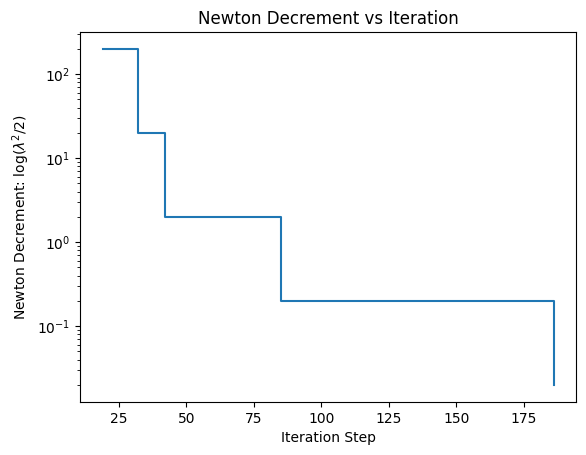

In [7]:
plt.step(np.cumsum(results['iter']), results['gap'], where='post')
plt.yscale('log')
plt.ylabel("Newton Decrement: log($\lambda^2 / 2 $)")
plt.xlabel("Iteration Step")
plt.title("Newton Decrement vs Iteration")

### LP Solver
Using the code from part (2), implement a general standard form LP
solver, that takes arguments $A, b, c$, determines (strict) feasibility, and returns an
optimal point if the problem is (strictly) feasible. <br> <br>
You will need to implement a phase I method, that determines whether the problem
is strictly feasible, and if so, finds a strictly feasible point, which can then be fed to
the code from part (2). In fact, you can use the code from part (2) to implement the
phase I method. <br> <br>
To find a strictly feasible initial point x0, we solve the phase I problem
\begin{align}
  \text{minimize} & \quad t \\
  \text{subject to} & \quad Ax =b \\
  & \quad x \succeq (1-t) \textbf{1}, \quad t \geq 0
\end{align}
with variables $x$ and $t$. If we can find a feasible $(x, t)$, with $t < 1$, then $x$ is strictly
feasible for the original problem. The converse is also true, so the original LP is strictly
feasible if and only if $t^* < 1$, where $t^*$
is the optimal value of the phase I problem. <br> <br>
We can initialize x and t for the phase I problem with any $x_0$
satisfying $Ax_0 = b$, and $t^0 = 2 - \min_i x_i^0$.(Here we can assume that $\min x_i^0 \leq 0$; otherwise $x^0$ is already a strictly feasible point, and we are done.)
You can use a change of variable $z= x + (t - 1) \textbf{1}$ to
transform the phase I problem into the form in part (2). <br> <br>
Check your LP solver against cvx on several numerical example s, including both feasible and infeasible instances.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
def create_problem_params(m=100,n=500, seed = None):
    if seed is not None:
        np.random.seed(seed)
    A = np.random.randn(m-1,n) * 10
    A = np.vstack((A, np.ones(n).reshape(1, -1)))
    b = np.random.rand(m)
    x_0 = np.linalg.lstsq(A, b, rcond=None)[0]
    c = np.random.rand(n) * 20 + 5

    return A, x_0, b, c

import numpy as np
def f(x:np.array, c:np.array):
    x = np.maximum(x, 1e-8)
    return c.T @ x - np.sum(np.log(x))

def g(x:np.array, c:np.array):
    return c - 1/x

def H(x:np.array,c:np.array = None):
    H = np.diag((x**(-2)))
    eI = np.identity(x.shape[0]) * 1e-9
    return H + eI

def H_inv(x: np.array, c:np.array = None):
    H_inv = np.diag((x**(2)))
    eI = np.identity(x.shape[0]) * 1e-9
    return H_inv + eI

def append_results(results, x, f_x, g_x, H_x, dx, lambda_2, iter, nu, gap = None):
    results["x"].append(x)
    results["f_x"].append(f_x)
    results["g_x"].append(g_x)
    results["H_x"].append(H_x)
    results["dx"].append(dx)
    results["lambda_2"].append(lambda_2)
    results["iter"].append(iter)
    results["nu"].append(nu)
    if gap is not None:
        results["gap"].append(gap)

def backtracking_line_search(x, dx, alpha, beta, c, f_x, g_x):
    t = 1
    while (f(x + t * dx,c) > f_x + alpha * t * g_x.T @ dx) or np.isnan(f(x + t * dx,c)):
        t *= beta
        if t < 1e-20:
            break
    return t

def newtons_centering_step(A, x_0, b, c, alpha, beta, epsilon, max_iter, verbose):
    # Storing results
    results = {
        "x": [],
        "f_x" : [],
        "g_x" : [],
        "H_x" : [],
        "dx": [],
        "lambda_2": [],
        "iter": [],
        "nu": [],
    }
    
    # Givens
    x = x_0
    i = 0


    while i <= max_iter:
        x = np.maximum(x, 1e-8)
        # Compute gradients and hessians
        f_x = f(x, c)
        g_x = g(x, c)
        H_x = H(x, c)
        H_x_inv = H_inv(x, c)
        

        # Compute Newton step and decrement
        w = np.linalg.solve(A @ H_x_inv @ A.T, -A @ H_x_inv @ g_x)
        dx_nt = - H_x_inv @ (A.T @ w + g_x)
        nt_dec_2 = - dx_nt.T @ g_x
        
        # Stopping Criterion
        if nt_dec_2 / 2 <= epsilon:
            break

        # Line Search
        t_search = backtracking_line_search(x, dx_nt, alpha, beta, c, f_x, g_x)
        
        # Update
        x = x + t_search * dx_nt

        # Iteration update
        i += 1

        # Append to results lists
        append_results(results, x, f_x, g_x, H_x, dx_nt, nt_dec_2, i, w)

    # Newton Complete Certificate
    p_star = x.shape[0] + np.sum(np.log(np.maximum(c + A.T @ w, 1e-9))) - w.T @ b  
    if verbose:
        print(f"""
        Newtons Step completed in {i} iterations
        Duality Gap f(x^*) - p^* = {f(x,c) - p_star}
        KKT conditions satisfied with accuracy of {np.linalg.norm(g(x,c) + w.T @ A,2)}
        """)
    return results

def newton_method_fs_lp(A, x_0, b, c, mu=20, alpha=0.1, beta=0.3, epsilon_inner=1e-8, epsilon_outer=1e-4, max_iter=100, verbose=False):
    # Results
    results = {
        "x": [],
        "f_x" : [],
        "g_x" : [],
        "H_x" : [],
        "dx": [],
        "lambda_2": [],
        "iter": [],
        "nu": [],
        "gap": [],
    }

    # Initialize variables
    x = np.maximum(x_0, 1e-8)
    i = 0

    # Initialize t
    t = 1 # DO THIS MORE INTELLIGENTLY

    while i <= max_iter:
        # Centering step
        inner_step_results = newtons_centering_step(A, x, b, c * t, alpha, beta, epsilon_inner, max_iter, verbose)
        x_t = inner_step_results["x"][-1]

        # Updating x
        x = x_t

        gap = x.shape[0] / t
        if gap <= epsilon_outer:
            break

        t *= mu

        append_results(results, 
                       x, 
                       inner_step_results["f_x"][-1] / t, 
                       inner_step_results["g_x"][-1], 
                       inner_step_results["H_x"][-1], 
                       inner_step_results["dx"][-1],
                       inner_step_results["lambda_2"][-1],
                       inner_step_results["iter"][-1],
                       inner_step_results["nu"][-1],
                       gap, 
                       )
        
        i += 1
    
    return results


def phase_1_init(A, x_0, b, c,  mu=20, alpha=0.1, beta=0.3, epsilon_inner=1e-8, epsilon_outer=1e-4, max_iter=100, verbose = False):
    # Problem Restructure
    n = x_0.shape[0]
    A_aug = np.c_[A, -A @ np.ones(n)]
    b_aug = b - A @ np.ones(n)
    t_0 =  2 + max(- np.min(x_0), 0)
    c_aug = np.r_[np.zeros(n),1]
    z = np.r_[x_0, t_0]

    results = newton_method_fs_lp(A_aug, z, b_aug, c_aug, mu, alpha, beta, epsilon_inner, epsilon_outer, max_iter, True)

    t_star = results["x"][-1][-1]
    x_star = results["x"][-1][:-1] - np.ones(n) * t_star + np.ones(n)

    if t_star > 1:
        print(f"""
        Problem is infeasible with t_star = {t_star:.2f}
        """)
        return None
    else:
        print(f"""
    Problem is strictly feasible with t_star = {t_star:.2f}
        """)

    return x_star



A, x_0, b, c = create_problem_params()
print(np.linalg.norm(A @ x_0 - b, 2))

x_0 = phase_1_init(A, x_0, b, c)

print(np.linalg.norm(A @ x_0 - b, 2))

# Phase 2 
results = newton_method_fs_lp(A, x_0, b, c)

results["f_x"]

1.4808144628747194e-14

        Newtons Step completed in 40 iterations
        Duality Gap f(x^*) - p^* = 1.001561026339914
        KKT conditions satisfied with accuracy of 1.1643392301630975e-10
        

        Newtons Step completed in 7 iterations
        Duality Gap f(x^*) - p^* = 20.03402237562068
        KKT conditions satisfied with accuracy of 4.871139768753869e-07
        

        Newtons Step completed in 7 iterations
        Duality Gap f(x^*) - p^* = 401.11394757152186
        KKT conditions satisfied with accuracy of 9.767866536066223e-06
        

        Newtons Step completed in 28 iterations
        Duality Gap f(x^*) - p^* = -7981.158325462997
        KKT conditions satisfied with accuracy of 1.7594747092940292e-07
        

        Newtons Step completed in 23 iterations
        Duality Gap f(x^*) - p^* = -159623.16650925355
        KKT conditions satisfied with accuracy of 0.010884923012613564
        

        Newtons Step completed in 19 iterations
        Du

[246.99718626772733,
 199.1877586239311,
 194.0090201972462,
 193.60761398416227,
 193.58042725773814,
 193.57871354772928]

In [6]:
results["x"][-1][-1]

3.93789784998747e-08

In [2]:
from newtons_method import newton_method_fs_lp, phase_1_init
from parameters import create_problem_params
from tests import cvx_lp, andy_lp

A, x_0, b, c = create_problem_params(seed=42)

prob_andy = newton_method_fs_lp(A, x_0, b, c,verbose=True)


prob, x = cvx_lp(A, b, c)
prob.value, prob_andy['f_x'][-1]


        Newtons Step completed in 12 iterations
        Duality Gap f(x^*) - p^* = -52.08485670538266
        KKT conditions satisfied with accuracy of 0.017392412892026678
        

        Newtons Step completed in 7 iterations
        Duality Gap f(x^*) - p^* = -42.669870402231936
        KKT conditions satisfied with accuracy of 0.0004285648432860331
        

        Newtons Step completed in 26 iterations
        Duality Gap f(x^*) - p^* = 25.800005465625873
        KKT conditions satisfied with accuracy of 0.5762705239652284
        

        Newtons Step completed in 101 iterations
        Duality Gap f(x^*) - p^* = 378.1462025077053
        KKT conditions satisfied with accuracy of 14278.207260262148
        

        Newtons Step completed in 101 iterations
        Duality Gap f(x^*) - p^* = 8714.960092567839
        KKT conditions satisfied with accuracy of 3853287.9390428746
        

        Newtons Step completed in 101 iterations
        Duality Gap f(x^*) - p^* = 20683

(13.038103118707859, 0.6427810479122757)

In [6]:
import numpy as np
np.linalg.norm(x.value -prob_andy['x'][-1],2)

45.18172848923713